In [1]:
#Reading and importing Libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
import warnings

# Suppress specific warnings (ValueWarnings and UserWarnings)
warnings.filterwarnings('ignore', category=UserWarning)  # Ignore UserWarnings
warnings.filterwarnings('ignore', category=Warning) 

In [4]:
df = pd.read_csv('Amazon.csv')

In [5]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


In [6]:
#EDA
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' to datetime format (if necessary)
df = df.set_index('Date')  # Set 'Date' as the index
df = df.asfreq('B') 

In [7]:
#Performing EDA, checking for null values.
print(df.isnull().sum())

Open         215
High         215
Low          215
Close        215
Adj Close    215
Volume       215
dtype: int64


In [8]:
#Dropping the weekend values, focusing mainly on the business data.
df = df.dropna()

In [9]:
#check Null Values again.

print(df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


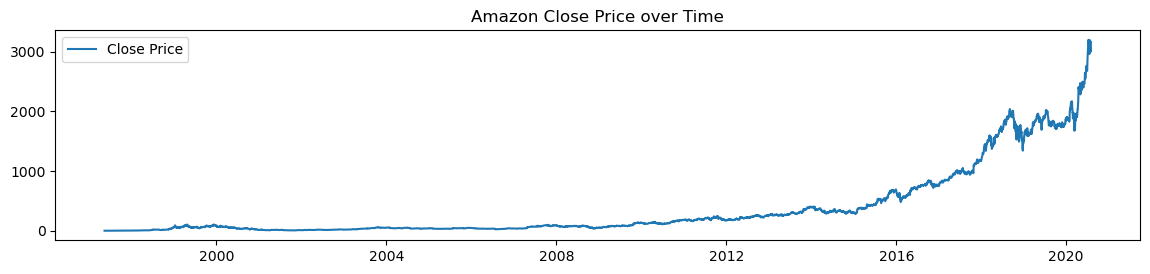

In [10]:
#Amazon Close Price Over time.
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(df['Close'], label='Close Price')
plt.title('Amazon Close Price over Time')
plt.legend()

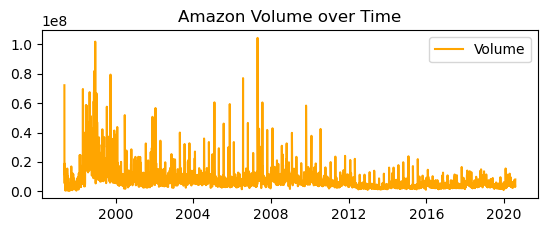

In [11]:
plt.subplot(2,1,2)
plt.plot(df['Volume'], label='Volume', color='orange')
plt.title('Amazon Volume over Time')
plt.legend()

In [12]:
#Case Study 1: Forecasting Close Price Using ARIMA
#Checking Stationairty
def check_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print(f"{title} is stationary.")
    else:
        print(f"{title} is NOT stationary.")

In [13]:
#Calling function for volume and close.
check_stationarity(df['Close'], 'Close')
check_stationarity(df['Volume'], 'Volume')

ADF Statistic for Close: 5.618546547149929
p-value: 1.0
Close is NOT stationary.
ADF Statistic for Volume: -4.940969225336506
p-value: 2.9005713411276226e-05
Volume is stationary.


In [14]:
#First differencing since Close is not stationary.
df['Close_diff'] = df['Close'].diff()

In [15]:
print("\nAfter Differencing:")
#Check Stationary After first differencing. Calling function again.
check_stationarity(df['Close_diff'], 'Close_diff')



After Differencing:
ADF Statistic for Close_diff: -11.871245852170034
p-value: 6.4958321141994555e-22
Close_diff is stationary.


Text(0.5, 1.0, 'ACF of Close_diff')

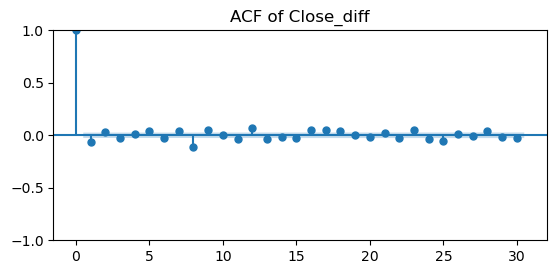

In [16]:
#ACF of Close
plt.figure(figsize=(14,6))
plt.subplot(2,2,1)
plot_acf(df['Close_diff'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF of Close_diff')

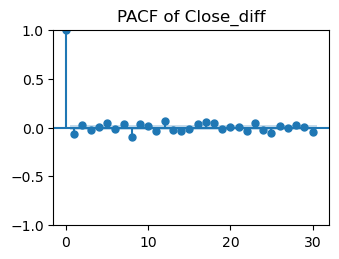

In [17]:
plt.subplot(2,2,2)
plot_pacf(df['Close_diff'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF of Close_diff')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ACF of Volume')

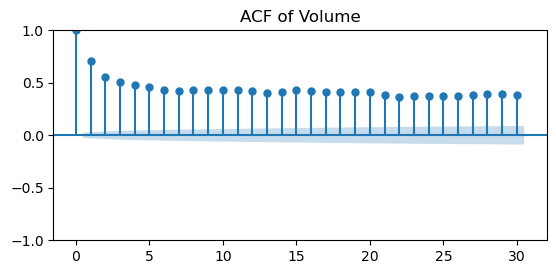

In [18]:
#ACF of Volume
plt.figure(figsize=(14,6))
plt.subplot(2,2,3)
plot_acf(df['Volume'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF of Volume')

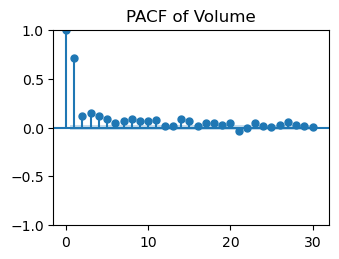

In [19]:
plt.subplot(2,2,4)
plot_pacf(df['Volume'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF of Volume')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
#Model Evaluation
#Split into Train/Test
train_size = int(len(df) * 0.8)
train_close = df['Close'][:train_size]
test_close = df['Close'][train_size:]

In [22]:
#Train ARIMA Model on Train Data
model_close = ARIMA(train_close, order=(2,0,1))
model_close_fit = model_close.fit()

In [23]:
#Forecast future close prices for the test set length
forecast_close = model_close_fit.forecast(steps=len(test_close))

In [24]:
#Ensure that both test_close and forecast_close have the same length
forecast_close = forecast_close[:len(test_close)]  # Slice forecast to match the length of test_close
test_close = np.log(test_close[test_close > 0])  # Apply log to positive values only
forecast_close = np.log(forecast_close[forecast_close > 0])

#Ensure that the lengths match after the transformation
print(len(test_close), len(forecast_close))

1169 1169


In [25]:
#Calculate MAE and RMSE
mae = mean_absolute_error(test_close, forecast_close)
rmse = np.sqrt(mean_squared_error(test_close, forecast_close))

print("\nClose Price Model Evaluation:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


Close Price Model Evaluation:
MAE: 0.6798642297653702
RMSE: 0.8016980132185826


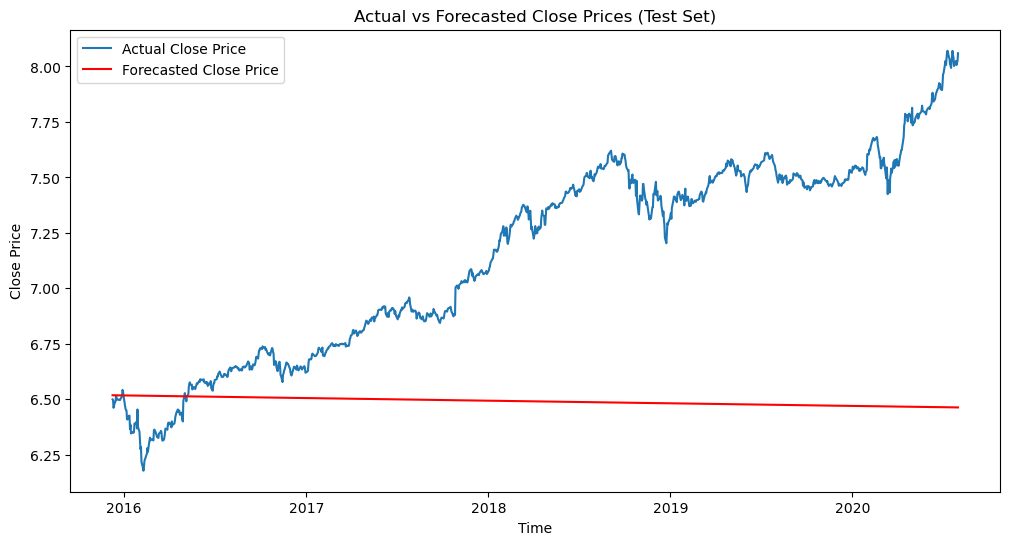

In [26]:
#Actual vs Forecasted Close Prices.
plt.figure(figsize=(12,6))
plt.plot(test_close.index, test_close, label='Actual Close Price')
plt.plot(test_close.index, forecast_close, label='Forecasted Close Price', color='red')
plt.title('Actual vs Forecasted Close Prices (Test Set)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [27]:
#Retrain model on full data
final_model_close = ARIMA(df['Close'], order=(5,0,1))
final_model_close_fit = final_model_close.fit()

In [28]:
#Forecast next 30 days
future_forecast_close = final_model_close_fit.forecast(steps=50)

In [29]:
#Generate the future dates
last_date = df['Close'].index[-1]  # Get the last date in the dataset
future_dates = pd.date_range(start=last_date, periods=51, freq='D')[1:]  # Generate next 30 days, excluding the last date

In [30]:
#Print the forecasted future dates with values
future_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Close Price': future_forecast_close
})

In [31]:
print(future_forecast_df)

           Date  Forecasted Close Price
5842 2020-08-01             3158.106688
5843 2020-08-02             3160.919093
5844 2020-08-03             3158.304086
5845 2020-08-04             3157.886868
5846 2020-08-05             3158.565171
5847 2020-08-06             3157.738934
5848 2020-08-07             3158.626467
5849 2020-08-08             3157.697951
5850 2020-08-09             3158.596540
5851 2020-08-10             3157.671587
5852 2020-08-11             3158.559870
5853 2020-08-12             3157.648491
5854 2020-08-13             3158.522481
5855 2020-08-14             3157.625626
5856 2020-08-15             3158.485073
5857 2020-08-16             3157.602684
5858 2020-08-17             3158.447767
5859 2020-08-18             3157.579630
5860 2020-08-19             3158.410577
5861 2020-08-20             3157.556460
5862 2020-08-21             3158.373503
5863 2020-08-22             3157.533176
5864 2020-08-23             3158.336544
5865 2020-08-24             3157.509779


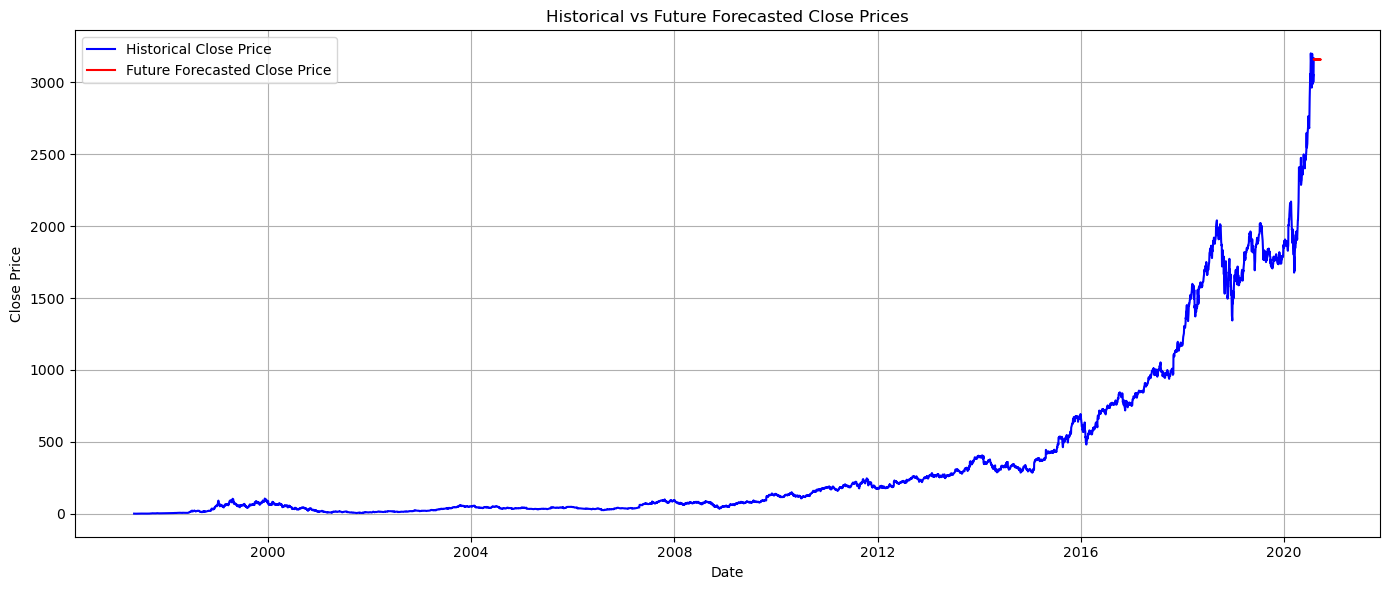

In [32]:
#Historical data
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], label='Historical Close Price', color='blue')

#Future forecast
future_forecast_dates = future_forecast_df['Date'].values  # use future_forecast_df instead of forecast
future_forecast_values = future_forecast_df['Forecasted Close Price'].values  # use future_forecast_df instead of forecast

plt.plot(future_forecast_dates, future_forecast_values, label='Future Forecasted Close Price', color='red')

#Customize the plot for future vs historical closed prices.
plt.title('Historical vs Future Forecasted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

#Show the plot
plt.tight_layout()
plt.show()

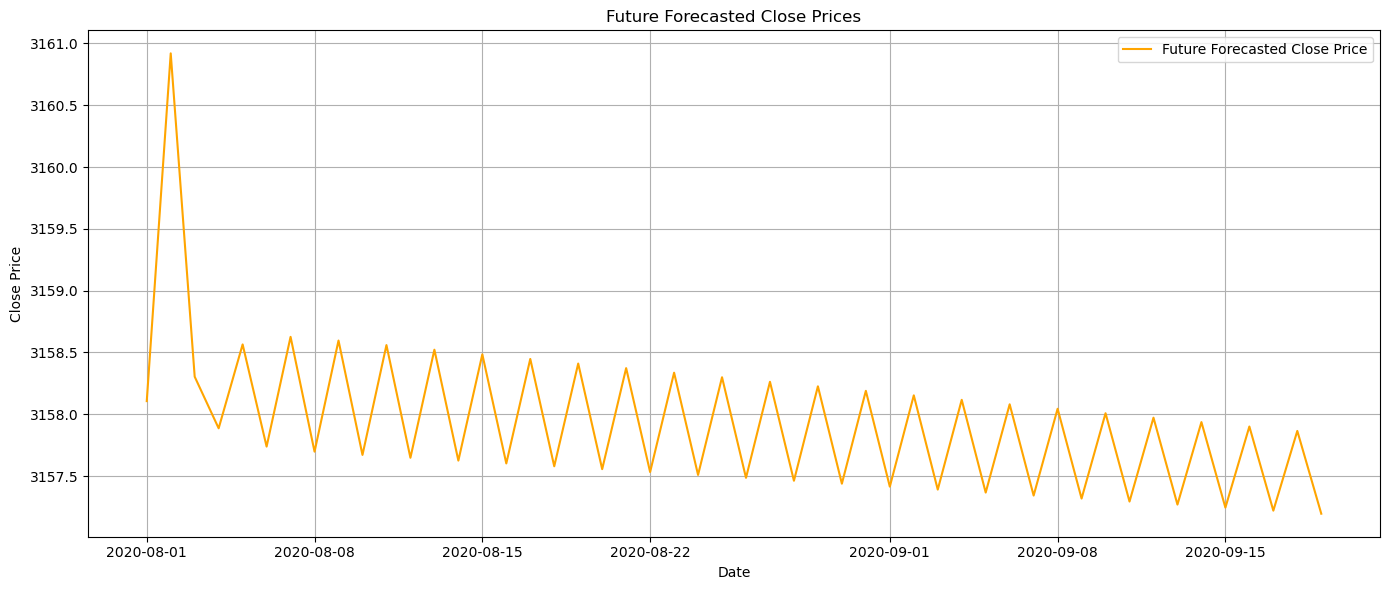

In [33]:
#Future forecast Close Price
plt.figure(figsize=(14, 6))
future_forecast_dates = future_forecast_df['Date'].values  # use future_forecast_df instead of forecast
future_forecast_values = future_forecast_df['Forecasted Close Price'].values  # use future_forecast_df instead of forecast

#Plot the forecasted values
plt.plot(future_forecast_dates, future_forecast_values, label='Future Forecasted Close Price', color='orange')

#Customize the plot
plt.title('Future Forecasted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

#Show the plot
plt.tight_layout()
plt.show()

In [34]:
pip install prophet

In [35]:
#Case Study 2: Forecasting Volume using Prophet
from prophet import Prophet

In [36]:
volume_df = df[['Volume']].copy()        #Copy only Volume
volume_df['ds'] = volume_df.index        #Bring index to column

In [37]:
volume_df = volume_df.rename(columns={'Volume': 'y'})  #Rename Volume to y
volume_df = volume_df[['ds', 'y']]   

In [38]:
print("Original 'y' values (Volume) before transformation:")
print(volume_df[['ds', 'y']].head())

Original 'y' values (Volume) before transformation:
                   ds           y
Date                             
1997-05-15 1997-05-15  72156000.0
1997-05-16 1997-05-16  14700000.0
1997-05-19 1997-05-19   6106800.0
1997-05-20 1997-05-20   5467200.0
1997-05-21 1997-05-21  18853200.0


In [39]:
#Scaling transformation using Log1p. 
volume_df['y'] = np.log1p(volume_df['y'])

In [40]:
print("\nTransformed 'y' values after applying log1p:")
print(volume_df[['ds', 'y']].head())


Transformed 'y' values after applying log1p:
                   ds          y
Date                            
1997-05-15 1997-05-15  18.094341
1997-05-16 1997-05-16  16.503358
1997-05-19 1997-05-19  15.624914
1997-05-20 1997-05-20  15.514277
1997-05-21 1997-05-21  16.752193


In [41]:
#Calling the Prophet model.
model = Prophet()
model.fit(volume_df)

13:29:06 - cmdstanpy - INFO - Chain [1] start processing
13:29:13 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
#Generate a future dataframe for the next 30 periods to forecast future values
future = model.make_future_dataframe(periods=30)

In [43]:
forecast = model.predict(future)

In [44]:
#Extract forecasted values and dates.
volume_forecast = forecast[['ds', 'yhat']] 

In [45]:
#Future Forecasting.
print("\nForecasted 'yhat' values before inverse transformation:")
print(volume_forecast.tail(20))


Forecasted 'yhat' values before inverse transformation:
             ds       yhat
5852 2020-08-11  15.153693
5853 2020-08-12  15.144842
5854 2020-08-13  15.145712
5855 2020-08-14  15.070830
5856 2020-08-15  17.149670
5857 2020-08-16  17.130101
5858 2020-08-17  14.979669
5859 2020-08-18  15.006181
5860 2020-08-19  15.011661
5861 2020-08-20  15.028704
5862 2020-08-21  14.971584
5863 2020-08-22  17.069488
5864 2020-08-23  17.069974
5865 2020-08-24  14.940253
5866 2020-08-25  14.987784
5867 2020-08-26  15.014234
5868 2020-08-27  15.051839
5869 2020-08-28  15.014523
5870 2020-08-29  17.131134
5871 2020-08-30  17.148916


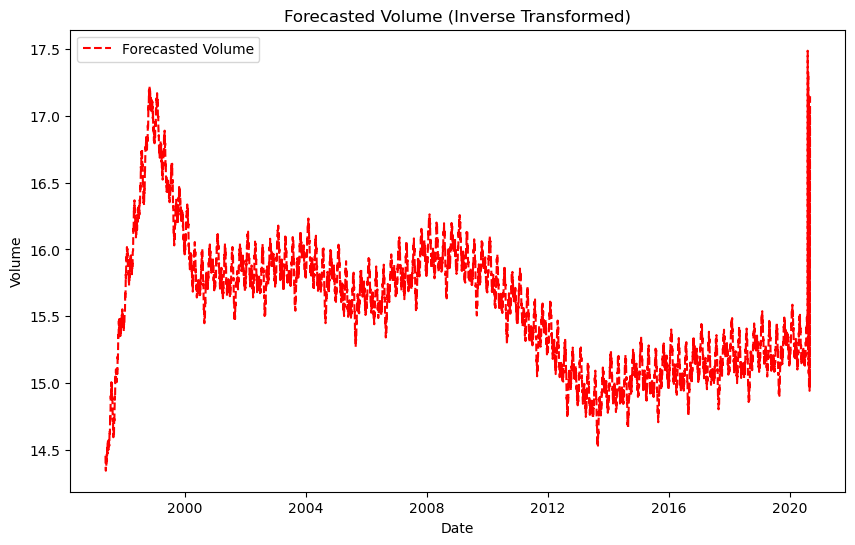

In [46]:
#Plotting the forecasted volume (Log Transformed)
plt.figure(figsize=(10,6))

#Plotting the forecasted volume after inverse transformation
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Volume', color='red', linestyle='--')

#Adding labels and title
plt.title('Forecasted Volume (Inverse Transformed)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


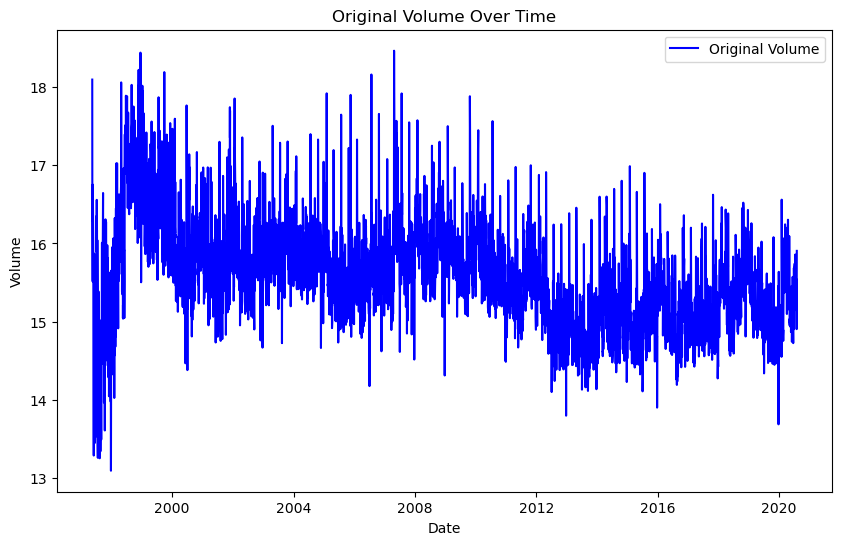

In [211]:
#Plotting the original volume data (log-transformed)
plt.figure(figsize=(10,6))
plt.plot( volume_df['ds'],volume_df['y'], label='Original Volume', color='blue')  # Raw volume, not log-transformed
plt.title('Original Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

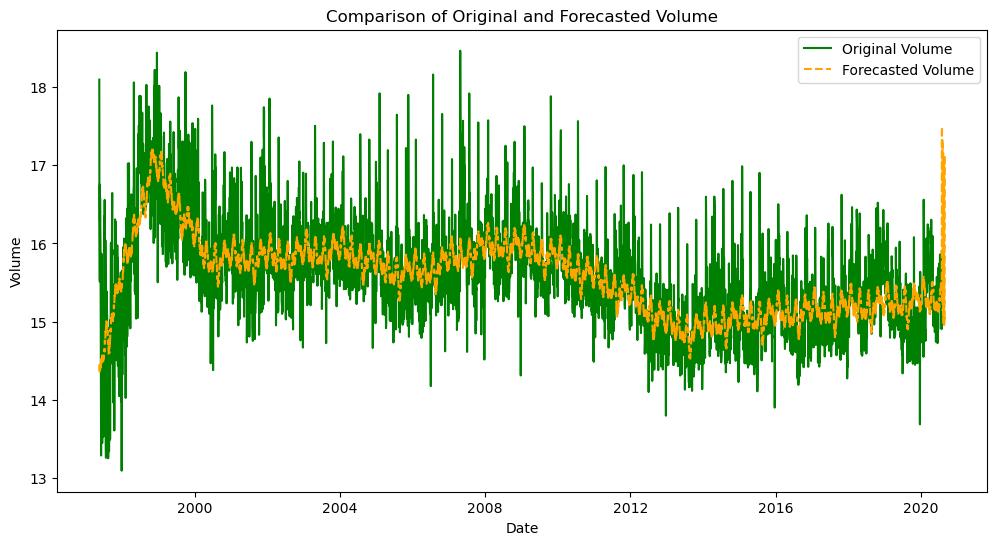

In [47]:
#Comparison of Original and Forecasted Volume
plt.figure(figsize=(12,6))

#Plot original volume
plt.plot(volume_df['ds'], volume_df['y'], label='Original Volume', color='green')

#Plot forecasted volume
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Volume', color='orange', linestyle='--')

#Adding labels and title
plt.title('Comparison of Original and Forecasted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


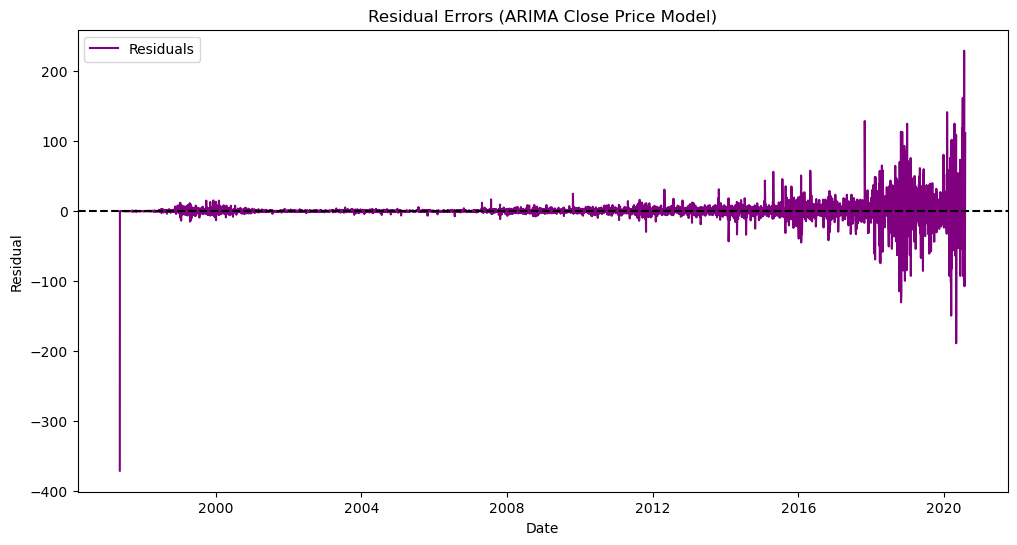

In [48]:
#Case study 3: Error Analysis
residuals = final_model_close_fit.resid 
#Plotting residuals
plt.figure(figsize=(12,6))
plt.plot(residuals, label='Residuals', color='purple')
plt.title('Residual Errors (ARIMA Close Price Model)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

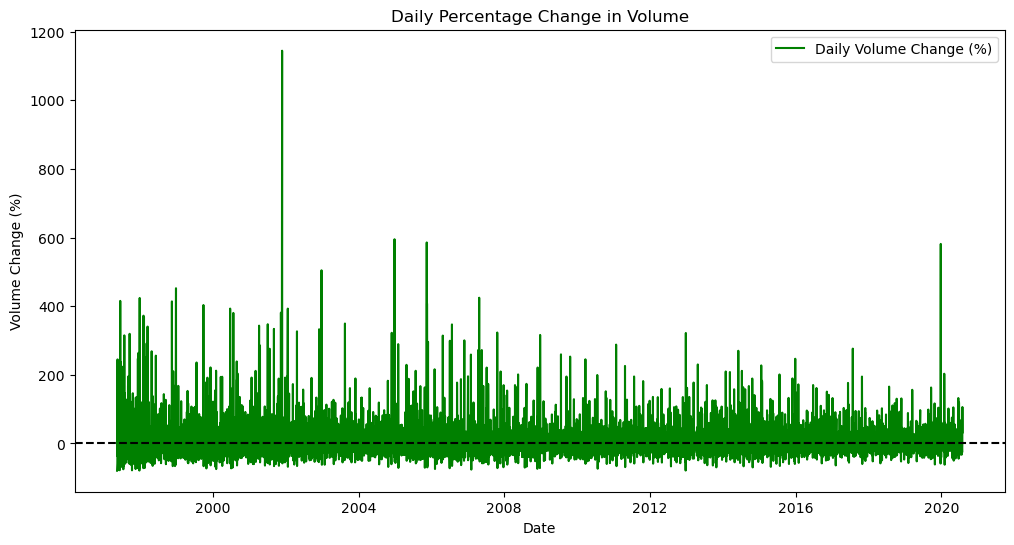

In [49]:
#Case study 4: Calculate daily volume change %
df['Volume Change %'] = df['Volume'].pct_change() * 100

#Plot
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Volume Change %'], label='Daily Volume Change (%)', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Daily Percentage Change in Volume')
plt.xlabel('Date')
plt.ylabel('Volume Change (%)')
plt.legend()
plt.show()

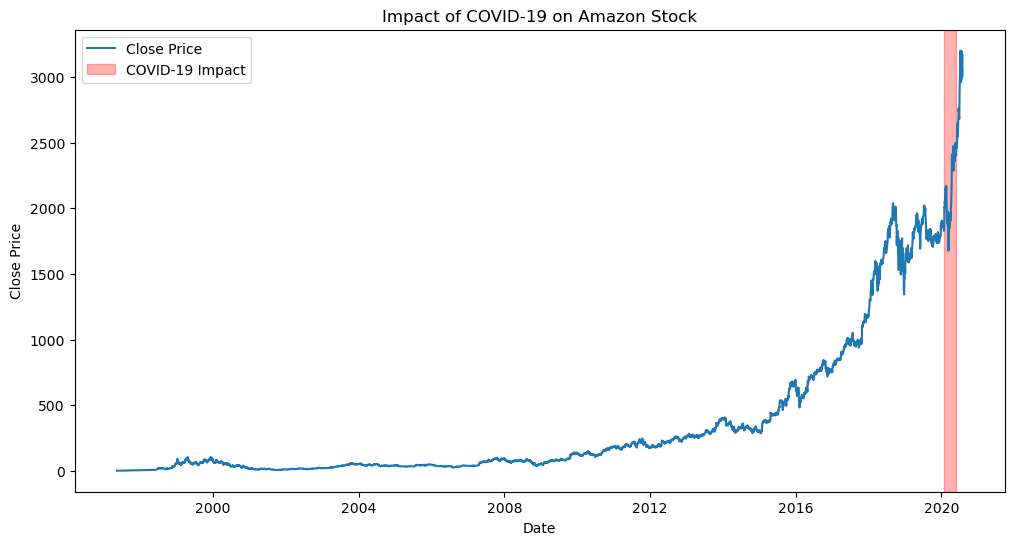

In [51]:
#Case Study 5: Even Impact Study
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.axvspan('2020-02-01', '2020-05-31', color='red', alpha=0.3, label='COVID-19 Impact')
plt.title('Impact of COVID-19 on Amazon Stock')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()